## Visualization for Ground Truth* and Predicted Trajectories

\* Shortest Path

### Instructions:
1. modified `3D/CheckConnectivity`
2. start a local server under directory `3D` by 
``` bash
# bash
cd preprocess/3D
python3 -m http.server```
3. make sure following paths are correct: 
``` python
# ground truth trajectory
trajectory_path = "tasks/R2R/results/val_seen_shortest_agent.json"  
# prediction trajectory
trajectory_path = "tasks/R2R/Nresults/seq2seq_sample_imagenet_val_seen_iter_16500.json"  
# instructions
instruction_path = "tasks/R2R/data/R2R_val_seen.json"
# connectivity information (where %s will be a scan ID)
graph_path = "connectivity/%s_connectivity.json"  
```
4. Never run the whole notebook together. You have to wait for `imgData= browser.execute_script...` to load images
5. After running the notebook, `./jolin_mesh_names.json` and `'./%s.json'% scan` will be genereated

In [12]:
import json, os

In [13]:
# Get all folders in mesh
folders = {}
files = os.listdir("./matterport_mesh/v1/scans/")
for id, name in enumerate(files):
    subfolder = os.listdir("./matterport_mesh/v1/scans/" + name + "/matterport_mesh/")
    folders[name]=subfolder[0]

In [14]:
def idx2scan_folder(idx, trajectory_data):
    trajectory = trajectory_data[idx]
    instr_id = trajectory['instr_id']
    scan = instr_id2scan[instr_id]
    txt = instr_id2txt[instr_id]
    return [scan, folders[scan]]

In [15]:
def traj2conn_json(graph_path, idx, trajectory_data):
    trajectory = trajectory_data[idx]
    instr_id = trajectory['instr_id']
    scan = instr_id2scan[instr_id]
    viewpointId2idx={}
    with open(graph_path % scan) as f:
        conn_data = json.load(f)
    for i,item in enumerate(conn_data):
        viewpointId2idx[item['image_id']]=i
    return trajectory, viewpointId2idx, conn_data

def gen_conns(trajectory, viewpointId2idx, conn_data):
    trajectory = trajectory_data[idx]
    node=conn_data[viewpointId2idx[trajectory['trajectory'][0][0]]]
    node={k:v for k,v in node.items()}
    node['unobstructed'] = [False]*len(trajectory['trajectory'])
    conns=[node]
    prev_viewpoint = node['image_id']
    for n, (viewpoint, heading, elevation) in enumerate(trajectory['trajectory'][1:]):
        node=conn_data[viewpointId2idx[viewpoint]]
        node={k:v for k,v in node.items()}
        prev_viewpoint = conns[-1]['image_id']
        if viewpoint != prev_viewpoint:
            assert node['unobstructed'][viewpointId2idx[prev_viewpoint]]
            node['unobstructed'] = [False]*len(trajectory['trajectory'])
            node['unobstructed'][len(conns)-1]=True
            conns.append(node)
    return conns

In [16]:
def build_dicts(trajectory_path, instruction_path):
    with open(trajectory_path) as f:
        trajectory_data = json.load(f)
    with open(instruction_path) as f:
        instruction_data = json.load(f)

    instr_id2txt = {
        ('%s_%d' % (d['path_id'], n)): txt for d in instruction_data for n, txt in enumerate(d['instructions'])}
    instr_id2scan = {
        ('%s_%d' % (d['path_id'], n)): d['scan'] for d in instruction_data for n, txt in enumerate(d['instructions'])}
    scan2trajidx = {
        instr_id2scan[traj['instr_id']]:idx for idx, traj in enumerate(trajectory_data)}
    instr_id2trajidx = {
        traj['instr_id']:idx for idx, traj in enumerate(trajectory_data)}
    return trajectory_data, instruction_data, instr_id2txt, instr_id2scan, scan2trajidx, instr_id2trajidx

# Start a local server

`cd /home/xql/Source/Subgoal/preprocess/3D
python3 -m http.server 8001`

In [39]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from IPython.display import display, HTML

options = Options()
options.headless = True
browser = webdriver.Chrome(executable_path="/home/nav/Tools/chromedriver", options=options)
url = "http://172.28.3.57:8001/connectivity.html"

# Specify the trajectory ID

In [40]:
instr_id ="6077_2"

# Ground Truth

In [41]:
trajectory_path = "/home/xql/Source/Subgoal/tasks/R2R/results/val_unseen_shortest_agent.json"

instruction_path = "/home/xql/Source/Subgoal/tasks/R2R/data/R2R_val_unseen.json"

graph_path = "/home/xql/Source/Subgoal/connectivity/%s_connectivity.json"

trajectory_data, instruction_data, instr_id2txt, instr_id2scan, scan2trajidx, instr_id2trajidx \
= build_dicts(trajectory_path, instruction_path)

idxs= [instr_id2trajidx[instr_id]]
scan_folders = [idx2scan_folder(idx, trajectory_data) for idx in idxs]
print(scan_folders)
instr_id = trajectory_data[idxs[0]]['instr_id']
print(instr_id)

# show instructions

instruction = instr_id2txt[instr_id]
print(instruction)
print('')
for i in ['0','1','2']:
    print(instr_id2txt[instr_id[:-1]+i])

[[u'zsNo4HB9uLZ', 'a641c3f4647545a2a4f5c50f5f5fbb57']]
6077_2
Exit the sitting room and turn left. Take the first turn to the right.Go straight and then turn left at the shelf. Walk into the first door on the right. 

Turn around and go passed the couch, then turn left and take an immediate right passed the painting. Turn left and go straight through the first door on the left. 
Turn left and exit the room.  Cross the hall to the sitting room.  Turn left and enter the bedroom on your left.  Wait near the bed. 
Exit the sitting room and turn left. Take the first turn to the right.Go straight and then turn left at the shelf. Walk into the first door on the right. 


### Dump connections

In [42]:
scan_folders = [idx2scan_folder(idx, trajectory_data) for idx in idxs]

with open('./jolin_mesh_names.json', 'w') as fp:
    json.dump(scan_folders, fp)

for idx, (scan, folder) in zip(idxs, scan_folders):
    with open('./%s.json'% scan, 'w') as fp:
        trajectory, viewpointId2idx, conn_data=traj2conn_json(graph_path, idx, trajectory_data)
        json.dump(gen_conns(trajectory, viewpointId2idx, conn_data), fp)

browser.get(url) #navigate to the page


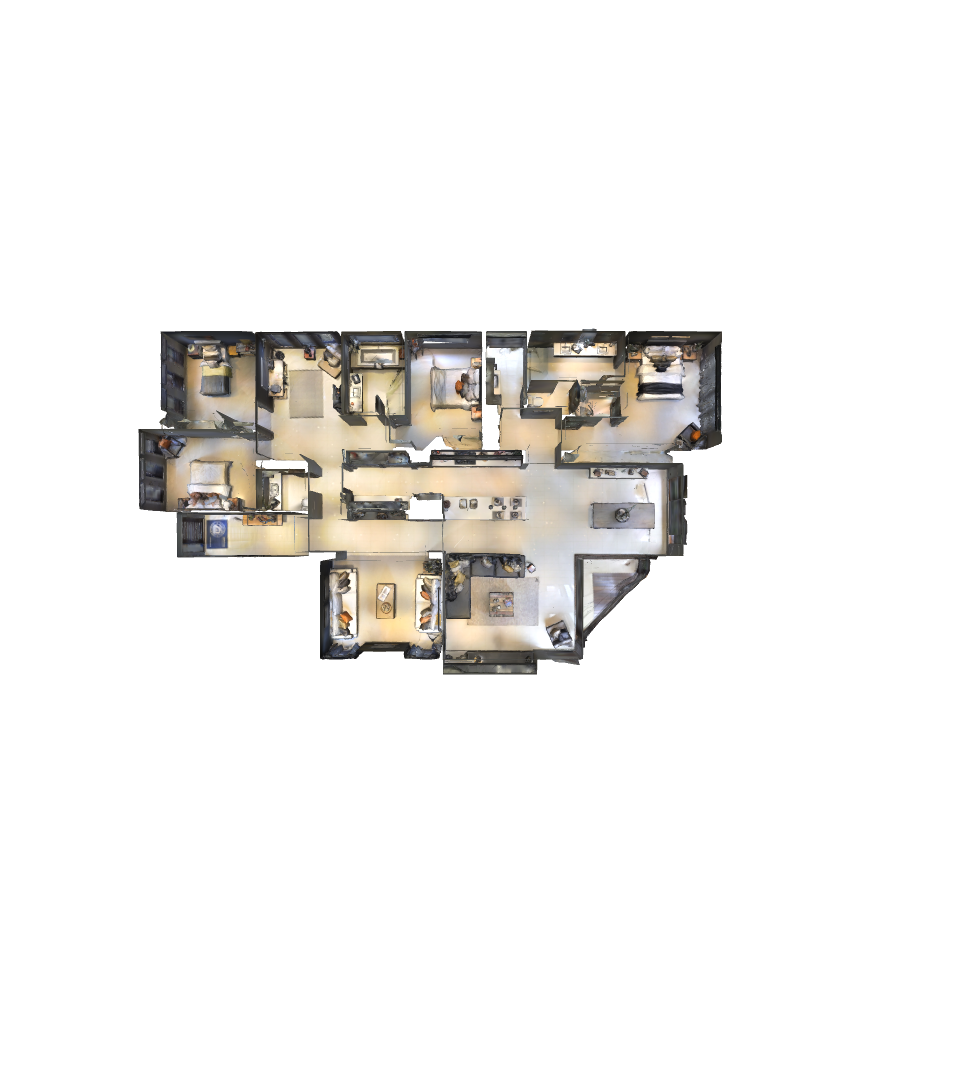

In [43]:
imgData= browser.execute_script('return renderer.domElement.toDataURL().replace("image/png", "image/octet-stream")')
display(HTML('''<img src="%s">'''%(imgData)))

In [23]:
# Predication1
trajectory_path = "/home/xql/Source/Subgoal/tasks/R2R/exps/Nresult-len8-bi-mean/seq2seq_sample_imagenet_val_unseen_iter_36000.json"

trajectory_data, instruction_data, instr_id2txt, instr_id2scan, scan2trajidx, instr_id2trajidx \
= build_dicts(trajectory_path, instruction_path)

idxs= [instr_id2trajidx[instr_id]]
print(instr_id2txt[instr_id])

### Dump connections

scan_folders = [idx2scan_folder(idx, trajectory_data) for idx in idxs]

with open('./jolin_mesh_names.json', 'w') as fp:
    json.dump(scan_folders, fp)

for idx, (scan, folder) in zip(idxs, scan_folders):
    with open('./%s.json'% scan, 'w') as fp:
        trajectory, viewpointId2idx, conn_data=traj2conn_json(graph_path, idx, trajectory_data)
        json.dump(gen_conns(trajectory, viewpointId2idx, conn_data), fp)

browser.get(url) #navigate to the page

Exit the sitting room and turn left. Take the first turn to the right.Go straight and then turn left at the shelf. Walk into the first door on the right. 



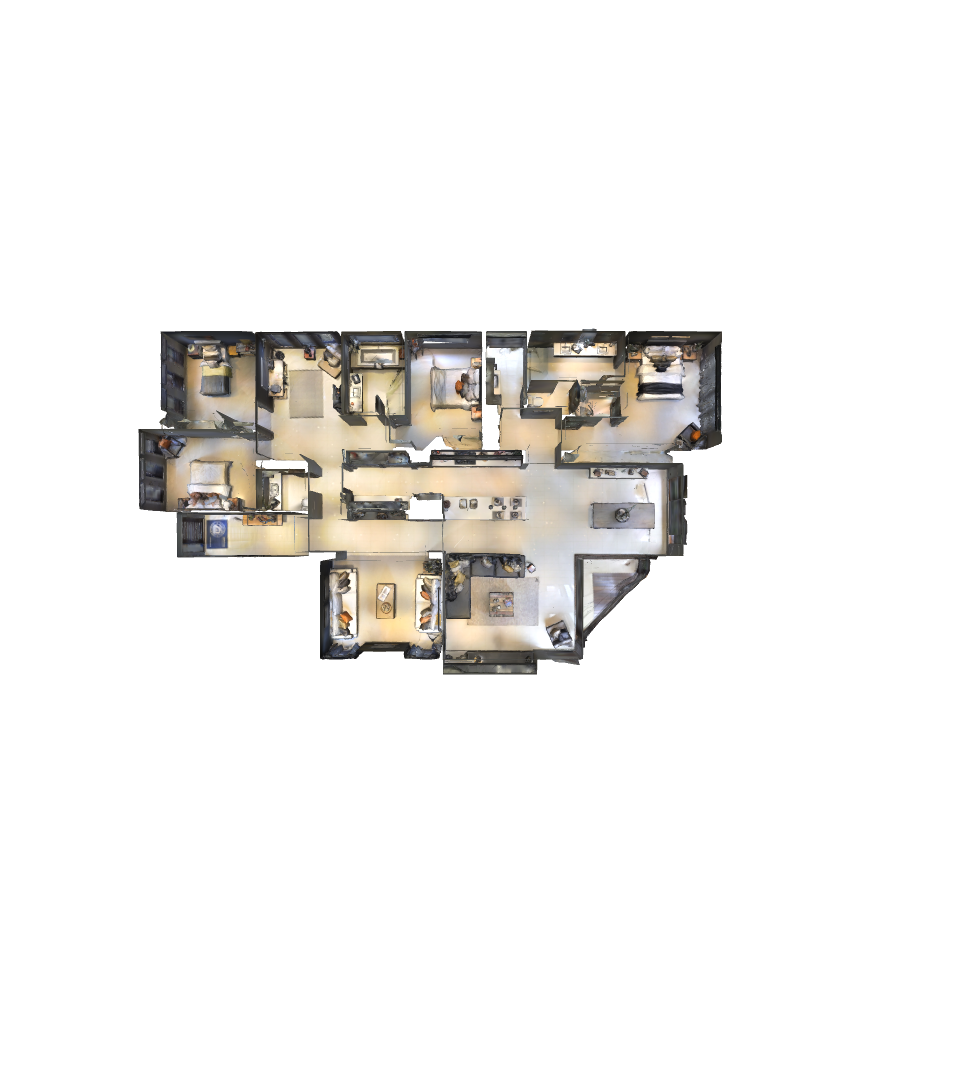

In [24]:
imgData= browser.execute_script('return renderer.domElement.toDataURL().replace("image/png", "image/octet-stream")')
display(HTML('''<img src="%s">'''%(imgData)))

In [32]:
# Predication2

trajectory_path = "/home/nav/Source/speaker_follower/tasks/R2R/eval_outputs/pragmatics_val_unseen_speaker_weight_0.00.json"

trajectory_data, instruction_data, instr_id2txt, instr_id2scan, scan2trajidx, instr_id2trajidx \
= build_dicts(trajectory_path, instruction_path)

idxs= [instr_id2trajidx[instr_id]]
print(instr_id2txt[instr_id])

### Dump connections

scan_folders = [idx2scan_folder(idx, trajectory_data) for idx in idxs]

with open('./jolin_mesh_names.json', 'w') as fp:
    json.dump(scan_folders, fp)

for idx, (scan, folder) in zip(idxs, scan_folders):
    with open('./%s.json'% scan, 'w') as fp:
        trajectory, viewpointId2idx, conn_data=traj2conn_json(graph_path, idx, trajectory_data)
        json.dump(gen_conns(trajectory, viewpointId2idx, conn_data), fp)

browser.get(url) #navigate to the page

Exit the sitting room and turn left. Take the first turn to the right.Go straight and then turn left at the shelf. Walk into the first door on the right. 



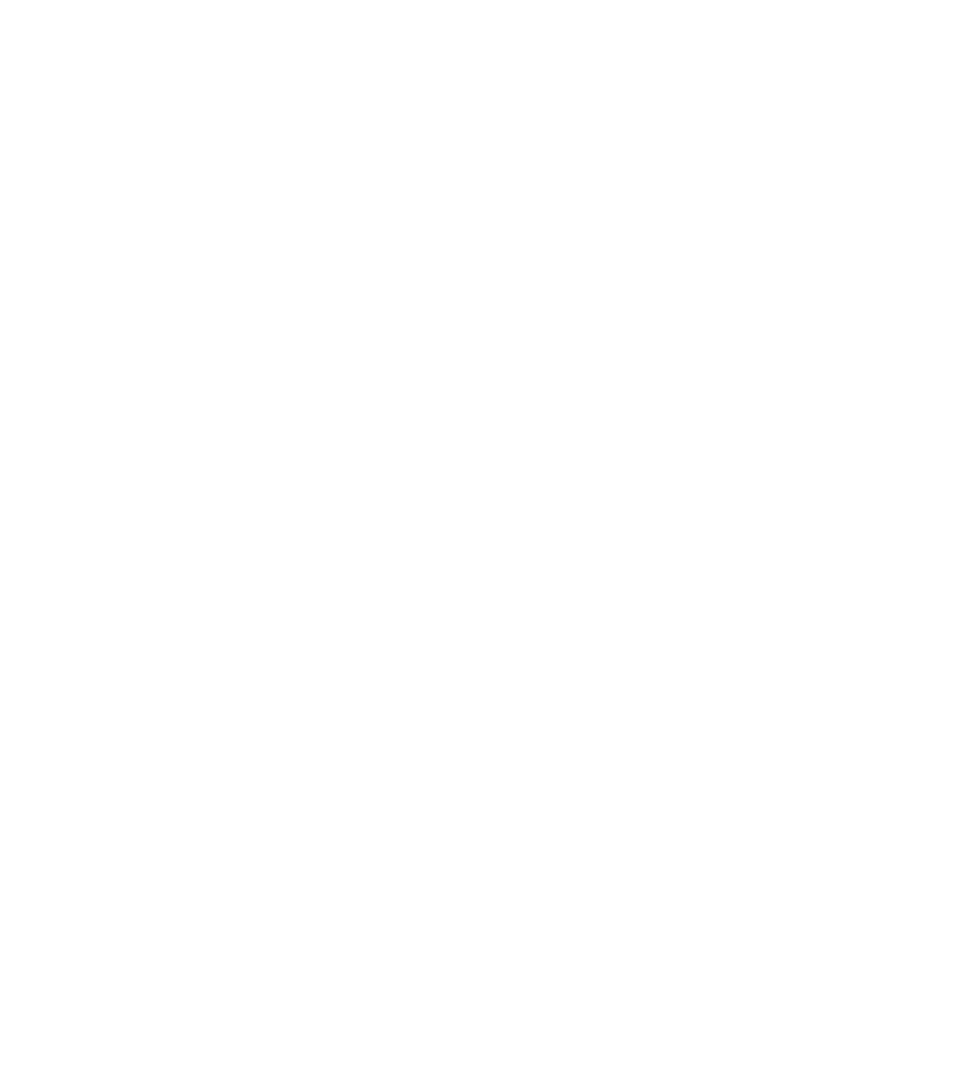

In [33]:
imgData= browser.execute_script('return renderer.domElement.toDataURL().replace("image/png", "image/octet-stream")')
display(HTML('''<img src="%s">'''%(imgData)))

In [15]:
# Predication3

trajectory_path = "/home/xql/Source/Subgoal/tasks/R2R/exps/baseline/seq2seq_sample_imagenet_val_unseen_iter_13100.json"

trajectory_data, instruction_data, instr_id2txt, instr_id2scan, scan2trajidx, instr_id2trajidx \
= build_dicts(trajectory_path, instruction_path)

idxs= [instr_id2trajidx[instr_id]]
print(instr_id2txt[instr_id])

### Dump connections

scan_folders = [idx2scan_folder(idx, trajectory_data) for idx in idxs]

with open('./jolin_mesh_names.json', 'w') as fp:
    json.dump(scan_folders, fp)

for idx, (scan, folder) in zip(idxs, scan_folders):
    with open('./%s.json'% scan, 'w') as fp:
        trajectory, viewpointId2idx, conn_data=traj2conn_json(graph_path, idx, trajectory_data)
        json.dump(gen_conns(trajectory, viewpointId2idx, conn_data), fp)

browser.get(url) #navigate to the page

Exit the sitting room and turn left. Take the first turn to the right.Go straight and then turn left at the shelf. Walk into the first door on the right. 



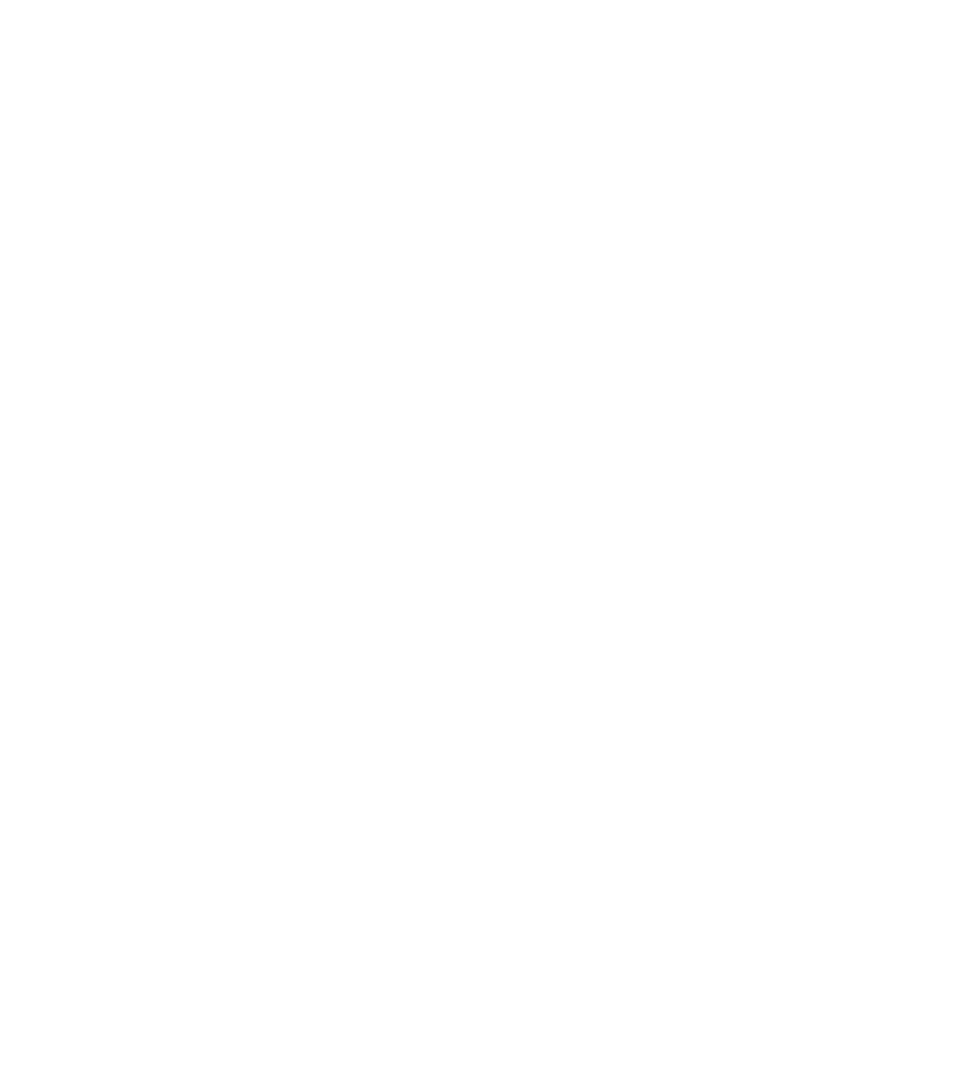

In [16]:
imgData= browser.execute_script('return renderer.domElement.toDataURL().replace("image/png", "image/octet-stream")')
display(HTML('''<img src="%s">'''%(imgData)))